## Imports

In [21]:
# import packages
import random
import noise
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import math
import matplotlib as mpl

## Parameters
<hr>
MODULATION - noise that changes the shape of geological layers in the z direction

- FREQ: Frequency, The number of cycles per unit length that a specific noise function outputs
- OCTAVES: How many layers of noise do we want to stack on top of each other - the more octaves the more fine detail
- PERSISTANCE: A multiplier that determines how quickly the amplitudes diminish for each successive octave in a Perlin-noise function.
- LACUNARITY: Change in frequency between octaves

For more info see:
https://libnoise.sourceforge.net/glossary/

<hr>

In [22]:
# parameters
LAYER_NUM = 12     # Number of geological layers
D_TAG_NUM = 3     # number of layers for debris

# grid size
PLOT_X = 50
PLOT_Y = 50
PLOT_Z = 50

# layer parameters
Z_SHIFT = .2
MODULATION_FREQ = 35.0
MODULATION_WEIGHT = .5
LAYER_OCTAVES = 6
LAYER_PERSISTANCE = .5
LAYER_LACUNARITY = 2.0

# debris parameters
DEBRIS_FREQ = 4
DEBRIS_OCTAVES = 2
DEBRIS_PERSISTANCE = .5
DEBRIS_LACUNARITY = 2
DEBRIS_LAYER_FALLOFF = .1
DEBRIS_DENSITY = .5

SEED = random.randint(1, 100)
PLOT_REPEAT = 4096

In [23]:
# graph params
LAYER_ALPHA = 0.8
DEBRIS_ALPHA = 1.0
COLOUR_MAP_NAME = 'plasma' #['viridis', 'plasma', 'inferno', 'magma', 'cividis'] https://matplotlib.org/stable/tutorials/colors/colormaps.html


colourMap = mpl.colormaps[COLOUR_MAP_NAME].resampled(LAYER_NUM + D_TAG_NUM).colors

for i in range(LAYER_NUM):
    colourMap[i] = (colourMap[i][0],colourMap[i][1],colourMap[i][2],LAYER_ALPHA)

for i in range(D_TAG_NUM):
    colourMap[LAYER_NUM+i] = (colourMap[LAYER_NUM+i][0],colourMap[LAYER_NUM+i][1],colourMap[LAYER_NUM+i][2],DEBRIS_ALPHA)

CUSTOM_CMAP = LinearSegmentedColormap.from_list('custom_cmap', colourMap)

## GridGen
<hr>

Loop 1
- build layers by modulating the Z position by a noise value

Loop 2
- saturate layers so they re between 0 an 1 (use min and max to linearly interpolate values)
- quantize colours - find the closest colour in LAYER_NUM size palette
- for each debris layer run noise and change layer to a layer between LAYER_NUM and LAYER_NUM + D_TAG_NUM

output a check, total layers should = setsize
<hr>

In [24]:
# Create an empty 3D array
data = np.zeros((PLOT_X, PLOT_Y, PLOT_Z))

# some statistics
minNum = 5555
maxNum = -5555
bz = 0
uz = 0
quantisedVals={-1}
quantisedVals.remove(-1)

# Generate 3D Perlin noise
for z in range(PLOT_X):
    for x in range(PLOT_Z):
        for y in range(PLOT_Y):
            # Modulated Layers
            data[z][y][x] = x / PLOT_Z
            data[z][y][x] += noise.pnoise3(
                x/MODULATION_FREQ,
                y/MODULATION_FREQ,
                z/MODULATION_FREQ,
                octaves=LAYER_OCTAVES,
                persistence=LAYER_PERSISTANCE,
                lacunarity=LAYER_LACUNARITY,
                repeatx=PLOT_REPEAT,
                repeaty=PLOT_REPEAT,
                repeatz=PLOT_REPEAT,
                base=SEED
            ) * MODULATION_WEIGHT



            # COLLECT STATS
            if data[z][y][x] > 0:
                uz += 1
            else:
                bz += 1

            data[z][y][x] = ((data[z][y][x] + Z_SHIFT) + 1) / 2
            data[z][y][x] = min(max(data[z][y][x], .0001), .9999)


            if data[z][y][x] < minNum:
                minNum = data[z][y][x]
            if data[z][y][x] > maxNum:
                maxNum = data[z][y][x]
            


# saturate and quantize 
for z in range(PLOT_X):
    for x in range(PLOT_Z):
        for y in range(PLOT_Y):
            
            # Saturate
            data[z][y][x] = (data[z][y][x] - minNum) / (maxNum - minNum)

            # quantize, add to set, and add debris 
            data[z][y][x] = math.floor(data[z][y][x] * (LAYER_NUM - 1))
            
            # Debris
            for i in range(D_TAG_NUM):
                debris = noise.pnoise3(
                    x/DEBRIS_FREQ * ((i+1)/10),
                    y/DEBRIS_FREQ * ((i+1)/10),
                    z/DEBRIS_FREQ * ((i+1)/10),
                    octaves=DEBRIS_OCTAVES,
                    persistence=DEBRIS_PERSISTANCE,
                    lacunarity=DEBRIS_LACUNARITY,
                    repeatx=PLOT_REPEAT,
                    repeaty=PLOT_REPEAT,
                    repeatz=PLOT_REPEAT,
                    base=SEED+i
                ) - DEBRIS_DENSITY
                if debris > 0:
                    data[z][y][x] = (LAYER_NUM + i) 

            data[z][y][x] /= LAYER_NUM + D_TAG_NUM
            
            quantisedVals.add(round(data[z][y][x], 3))


print(f"{minNum} : {maxNum}   - share below 0 {bz}    share above 0 {uz}")
print(f"Layer: {LAYER_NUM}, Debris:{D_TAG_NUM}, TOTAL: {LAYER_NUM+D_TAG_NUM - 1}, setSize: {len(quantisedVals)}")
print(quantisedVals)



0.5100249037146568 : 0.9999   - share below 0 6369    share above 0 118631
Layer: 12, Debris:3, TOTAL: 14, setSize: 14
{0.133, 0.267, 0.2, 0.067, 0.333, 0.4, 0.467, 0.533, 0.6, 0.667, 0.0, 0.933, 0.733, 0.867}


## Use matplotlib to visualise the plot
<hr>

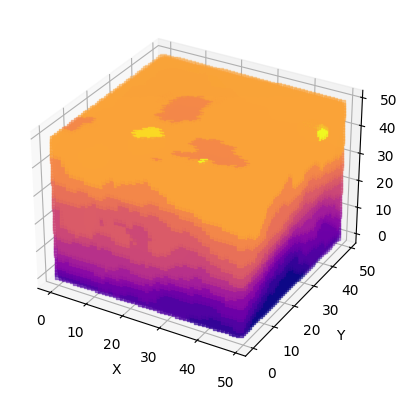

In [25]:
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Generate meshgrid for x, y, and z coordinates
x_coords = np.linspace(0, PLOT_X - 1, PLOT_X)
y_coords = np.linspace(0, PLOT_Y - 1, PLOT_Y)
z_coords = np.linspace(0, PLOT_Z - 1, PLOT_Z)
x_mesh, y_mesh, z_mesh = np.meshgrid(
    x_coords,
    y_coords,
    z_coords
)

# Display the 3D noise as a scatter plot
ax.scatter(x_mesh, y_mesh, z_mesh, c=data.flatten(), cmap=CUSTOM_CMAP, marker='s')#, alpha=GRAPH_ALPHA)
plt.show()